### Create a Synthetic Dataset with a Class Distribution

The `make_blobs()` function will always create a synthetic datasets with an equal class distribution. We can use this function to create a synthetic dataset with arbitrary class distribution.

In [53]:
import numpy as np
from matplotlib import pyplot
from sklearn.datasets import make_blobs
from typing import Dict, Tuple
from collections import Counter

array = np.array

# crete a dataset with a given class dist. 
def get_dataset(proportions: Dict[int,int], n_features:int=2)-> Tuple[array]:
    # num of classes
    n_classes = len(proportions)
    # num of samples required
    largest = max(proportions.values())
    n_samples = largest * n_classes
    # create dataset
    X, y = make_blobs(n_samples=n_samples, centers= n_classes,
                     n_features=n_features, random_state=42,
                     cluster_std=3)
    # collect examples
    X_list, y_list = list(), list()
    for k, v in proportions.items():
        row_ix = np.where(y==k)[0]#output is tuple, access the array
        selected = row_ix[:v]
        X_list.append(X[selected,:])
        y_list.append(y[selected])
    return np.vstack(X_list), np.hstack(y_list)


def plot_dataset(X:array,y:array)->None:
    n_classes = len(np.unique(y))
    for class_val in range(n_classes):
        row_ix = np.where(y == class_val)[0]
        pyplot.scatter(x= X[row_ix, 0],
                      y= X[row_ix, 1],
                      label = str(class_val))
    pyplot.title(f"Imbalanced y at {proportions}")
    pyplot.legend()
    pyplot.show()    

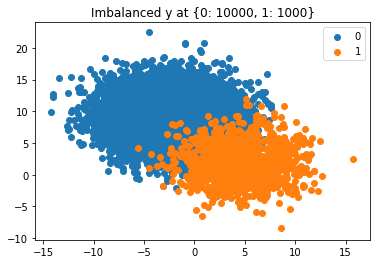

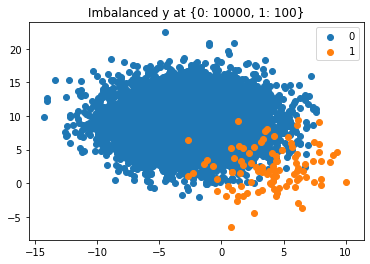

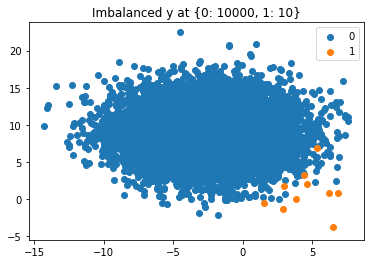

In [55]:
ratios = [1/10, 1/100, 1/1000]
largest_size = 10_000
proportions[0] = largest_size
for ratio in ratios:
    proportions[1] = int(largest_size * ratio)
    X, y = get_dataset(proportions=proportions)
    plot_dataset(X, y)

As we increase the ration in proportions the relationship between classes is more difficult to separate. The last example 1/1000 examples 
show how difficult could be for a model to detect the few examples of 1 class. 
With such a lack of data, we can see that on modeling problems with such a dramatic skew, that we should probably spend a lot of time on the actual minority examples that are available and see if domain knowledge can be used in some way.  Automatic modeling methods will have a tough challenge.

This example also highlights another important aspect orthogonal to the class distribution and that is the number of examples.  For example, although the dataset has a 1:1000 class distribution, having only 10 examples of the minority class is very challenging.  Although, if we had the same class distribution with 1,000,000 of the majority class and 1,000 examples of the minority class, the additional 990 minority class examples would likely be invaluable in developing an effective model.

in the next section we further explore the compound effect of additional properties such as label noise, size and data distribution can have to increase the challenge of imbalanced classification.

## Why imbalanced classification is hard

Imbalanced Dataset is defined by a dataset with skewed class distribution. This is often exemplified by a binary class task were most of the examples fit :

- A negative class 0 , with the majority of examples and a lack of the response sought 
- A positive class 1, with the minority of examples and the observed response we are interested. 

Because the class distribution is not balanced, most machine learning algorithms will perform poorly and require modification to avoid simply predicting the majority class in all cases. 

Misclassifying an example of the minority class is called a false positive an error but less critical that failing to verify a minority class event (False Negative). This is often referred as the cost sensitivity of the model. 

Skewed class distribution and cost sensitivity are typically referenced when describing the difficulty of imbalanced classification. However, there are other characteristics of the classification problem that, when combined with this properties, *compund* their effect. The three most common according:

- Dataset Size

- Label Noise

- Data Distribution

It's in important to acknowledge these properties. The below code is used to develop an intuition for their impact in a classification problem.  

### Dataset size

Dataset size refers to the number of n samples used to fit the model. Typically more data is better as it provides more coverage of the domain, perhaps to a point of diminishing returns. Specifically, more data provides better representation of the combinations and variance of features in the feature space and their mapping to class labels. 

Without a sufficient large training set, a classifier may not generalize characteristics of the data. Additionally the classifier could also overfit the training data, with poor performance in out of sample tests instances. 
To demonstrate the compound effect of dataset size the below code tries do demonstrate this challenge. A ratio of 1:100 for this imbalanced data set is applied but tested with a different number of samples.

In [56]:
import numpy as np
from sklearn.datasets import make_classification
from collections import Counter
from matplotlib import pyplot

Size=100, ratio=Counter({0: 99, 1: 1})
Size=1000, ratio=Counter({0: 990, 1: 10})
Size=10000, ratio=Counter({0: 9900, 1: 100})
Size=100000, ratio=Counter({0: 99000, 1: 1000})


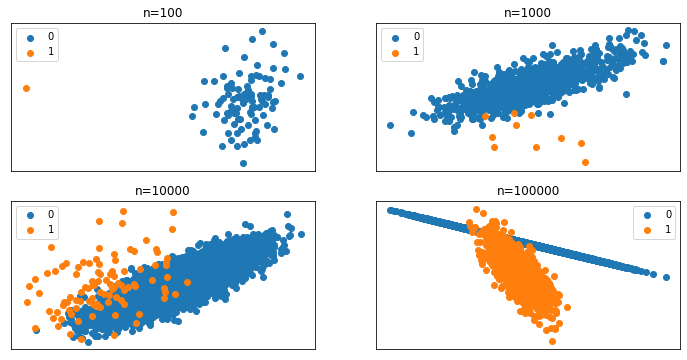

In [58]:
# effect on dataset size on 1:100 skew
seed = 1
# dataset sizes
sizes = [100, 1000, 10000, 100000]
pyplot.subplots(nrows=2, ncols=2, figsize=(12,6))
for i, n in enumerate(sizes):
# create te dataset
    X, y = make_classification(n_samples=n, n_features=2, n_redundant=0, 
                               n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=seed)
    counter = Counter(y)
    print(f"Size={n}, ratio={counter}")
    # define subplot
    pyplot.subplot(2,2, 1+i)
    pyplot.title(f"n={n}")
    pyplot.xticks([])
    pyplot.yticks([])
    # scatter plot of examples by class labels
    for label in counter.keys():
        row_ix = np.where(y == label)[0]
        pyplot.scatter(x = X[row_ix, 0], y = X[row_ix, 1], label=str(label))
    pyplot.legend()


It's hard to see a how a regular model could cope with only 10 examples of the minority class. Dataset size is a factor in detecting the minority class. As a know strategy of tackling imbalanced learn is to collect more data. 

#### Compounding Effect of Label Noise

Label Noise refers to examples that belong to one class that are labeled as another class. This can make determining class boundary in feature space problematic for most machine learning algorithms, and this difficult typically increases in 
proportion to the percentage of noise in the labels.

Two types of noise are distinguished in the literature: 

- feature 
- and class noise. 

Class noise is generally assumed to be more harmful than attribute noise in ML. Class noise affects the observed class values (e.g. by somehow flipping the label of a minority class instance to the majority class label).

Given that examples in the positive class are so few, losing some to noise reduces the amount of information available for the minority class. Additionally, having the samples form the majority class incorrectly marked as belonging to the minority class can cause a disjoint or fragmentation of the minority class that is already sparse due to the lack of observations.

Mislabeled minority class instances will contribute to increase the perceived imbalance ratio, as well as, introduce mislabeled noisy instances inside the class region of the minority class. (Recall decrease)

On the other hand, mislabeled majority class instances may lead to a learning algorithm  , or imbalanced treatment methods, to focus on the wrong areas of input space. (False Positive rate increase) 

We can develop an intuition by using a dataset with a know class imbalance 1:100 and size 1000 samples. We will add noise to "flip" the percentage of examples mislabeled for the minority class. 


Noise=0%, ratio=Counter({0: 990, 1: 10})
Noise=1%, ratio=Counter({0: 983, 1: 17})
Noise=5%, ratio=Counter({0: 963, 1: 37})
Noise=7%, ratio=Counter({0: 959, 1: 41})


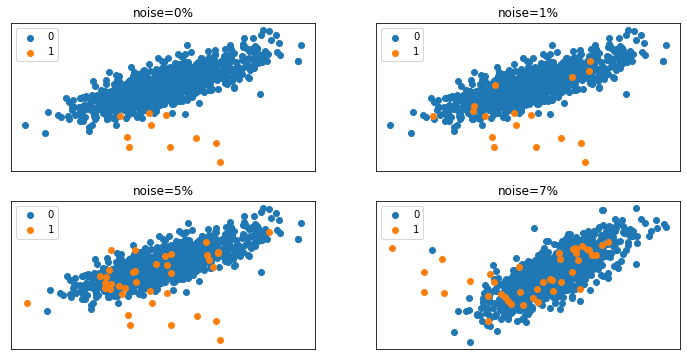

In [4]:
# label noise ratios
n_samples = 1000
noise = [0, 0.01, 0.05, 0.07]
pyplot.subplots(2,2, figsize=(12,6))
for i, n in enumerate(noise):
# create te dataset
    X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, 
                               n_clusters_per_class=1, weights=[0.99], 
                               flip_y=n, random_state=seed)
    counter = Counter(y)
    print(f"Noise={int(n * 100)}%, ratio={counter}")
    # define subplot
    pyplot.subplot(2,2, 1+i)
    pyplot.title(f"noise={int(n * 100)}%")
    pyplot.xticks([])
    pyplot.yticks([])
    # scatter plot of examples by class labels
    for label in counter.keys():
        row_ix = np.where(y == label)[0]
        pyplot.scatter(x = X[row_ix, 0], y = X[row_ix, 1], label=f'{label}')
    pyplot.legend()
    
    


We might expect he additional 31 examples from the majority  flipped as part of minority class (false positives) would increase the difficulty of a model to learn the correct class boundary in the feature space. 

### Compounding the Effect of Data Distribution

If we think about feature space spatially, we might like all examples in one class to be located on one part of the space, and those from the other class to appear in another part of the space. If this is the case, we have good class separability and machine learning models can draw crisp class boundaries and achieve good class performance. 

However the above is **rarely** the case. It is more likely that each class has multiple concepts resulting in multiple different groups(clusters) in feature space. It is common that the "concept" beneath a class is split into several sub-concepts, spread over the input space.

We can use the number of cluster in the dataset as a proxy for concepts and compare a dataset with one cluster per class to a second dataset with two cluster per class. 

In a 1:100 dataset , we would expect the increase in number of cluster for the majority class to be obvious for the majority class, but not so for the minority.  

n_clusters=1, ratio=Counter({0: 9900, 1: 100})
n_clusters=2, ratio=Counter({0: 9900, 1: 100})


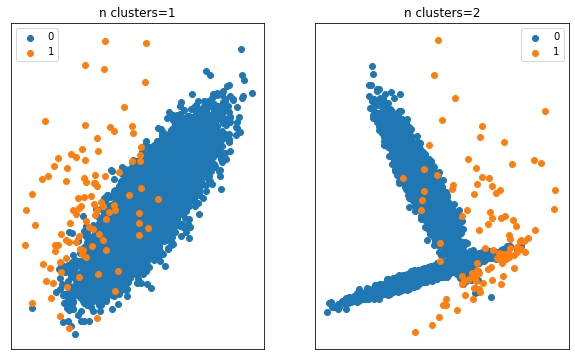

In [61]:
# vary the number of clusters for 1:100 imbalanced dataset
seed = 1
n_samples = 10000
clusters = [1,2]
pyplot.subplots(1,2, figsize=(10,6))
for i, c in enumerate(clusters):
# create te dataset
    X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, 
                               n_clusters_per_class=c, weights=[0.99], flip_y=0, random_state=seed)
    counter = Counter(y)
    print(f"n_clusters={c}, ratio={counter}")
    # define subplot
    pyplot.subplot(1,2, 1+i)
    pyplot.title(f"n clusters={c}")
    pyplot.xticks([])
    pyplot.yticks([])
    # scatter plot of examples by class labels
    for label in counter.keys():
        row_ix = np.where(y == label)[0]
        pyplot.scatter(x = X[row_ix, 0], y = X[row_ix, 1], label=f'{label}')
    pyplot.legend()
    
    


In the first example(left) the majority class (blue) quite clearly has none cluster, whereas the structure of the minority class (orange) is less obvious. In the second plot(right), the number of cluster is even more evident for the majority class in blue, but clearly the increase of clusters for the minority class has increase dispersion and not apparent the samples are part of 2 clusters. 

### Summary

In summary:

- Imbalanced classification is specifically hard because of the severely skewed class distribution and the unequal misclassification costs.
- The difficulty of imbalanced classification is compounded by properties such as dataset
size, label noise, and data distribution.
- How to develop an intuition for the compounding effects on modeling difficulty posed by
different dataset properties.